In [ ]:
print("Hello world")

Hello world


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the Transformer model
class Transformer(tf.keras.Model):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, dff, max_seq_length, rate=0.1):
        super(Transformer, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        # Embedding layers
        self.embedding = layers.Embedding(vocab_size, d_model)
        self.pos_encoding = positional_encoding(max_seq_length, self.d_model)

        # Transformer layers
        self.encoder_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        # Dropout layer
        self.dropout = layers.Dropout(rate)

    def call(self, inputs, training):
        seq_length = tf.shape(inputs)[1]

        # Add embeddings and positional encodings
        x = self.embedding(inputs)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_length, :]

        x = self.dropout(x, training=training)

        # Pass through each encoder layer
        for i in range(self.num_layers):
            x = self.encoder_layers[i](x, training)

        return x

# Define the positional encoding function
def positional_encoding(position, d_model):
    angle_rads = get_angles(tf.range(position, dtype=tf.float32)[:, tf.newaxis],
                            tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
                            d_model)

    # Apply sin to even indices in the array
    sines = tf.math.sin(angle_rads[:, 0::2])

    # Apply cos to odd indices in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    return tf.cast(pos_encoding, tf.float32)

# Define the positional encoding angles function
def get_angles(position, i, d_model):
    angle_rates = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angle_rates

# Define the EncoderLayer class
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = layers.MultiHeadAttention(num_heads, d_model)
        self.ffn = tf.keras.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model)
        ])

        self.layer_norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.mha(inputs, inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layer_norm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layer_norm2(out1 + ffn_output)

        return out2

# Define hyperparameters
vocab_size = 10000
d_model = 512
num_layers = 6
num_heads = 8
dff = 2048
max_seq_length = 100
rate = 0.1

# Initialize and compile the model
transformer = Transformer(vocab_size, d_model, num_layers, num_heads, dff, max_seq_length, rate)
transformer.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Generate some random input data
inputs = tf.random.uniform((32, max_seq_length), dtype=tf.int64, minval=0, maxval=vocab_size)

# Make a prediction
predictions = transformer(inputs, training=True)
print(predictions.shape)  # Output shape: (batch_size, max_seq_length, d_model)


(32, 100, 512)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

class TemporalFusionTransformer(tf.keras.Model):
    def __init__(self, input_size, output_size, num_encoder_steps, num_decoder_steps, d_model=64, num_heads=2, dff=128, rate=0.1):
        super(TemporalFusionTransformer, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.num_encoder_steps = num_encoder_steps
        self.num_decoder_steps = num_decoder_steps
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff

        # Embedding layers
        self.encoder_embedding = layers.Embedding(input_size, d_model)
        self.decoder_embedding = layers.Embedding(output_size, d_model)

        # Positional encoding
        self.pos_encoding = self.positional_encoding(num_encoder_steps + num_decoder_steps, d_model)

        # Transformer layers
        self.encoder_layers = [layers.MultiHeadAttention(num_heads, d_model) for _ in range(num_encoder_steps)]
        self.decoder_layers = [layers.MultiHeadAttention(num_heads, d_model) for _ in range(num_decoder_steps)]

        # Feedforward network
        self.ffn = tf.keras.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(output_size)
        ])

    def call(self, inputs, training=True):
        x, y = inputs

        # Embedding and positional encoding for encoder inputs
        encoder_inputs = self.encoder_embedding(x) + self.pos_encoding
        encoder_outputs = encoder_inputs

        # Encoder
        for layer in self.encoder_layers:
            encoder_outputs = layer(encoder_outputs, encoder_outputs, encoder_outputs, training=training)

        # Embedding and positional encoding for decoder inputs
        decoder_inputs = self.decoder_embedding(y) + self.pos_encoding
        decoder_outputs = decoder_inputs

        # Decoder
        for layer in self.decoder_layers:
            decoder_outputs = layer(decoder_outputs, encoder_outputs, encoder_outputs, training=training)

        # Final output
        outputs = self.ffn(decoder_outputs[:, -self.num_decoder_steps:, :])

        return outputs

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(tf.range(position, dtype=tf.float32)[:, tf.newaxis], tf.range(d_model, dtype=tf.float32)[tf.newaxis, :], d_model)
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def get_angles(self, position, i, d_model):
        angle_rates = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angle_rates

# Example usage
input_size = 1000  # Vocabulary size or unique values for encoder input
output_size = 1    # Output size for decoder output
num_encoder_steps = 24  # Number of encoder steps
num_decoder_steps = 6   # Number of decoder steps
d_model = 64    # Dimensionality of model
num_heads = 2   # Number of attention heads
dff = 128       # Dimensionality of feedforward network

# Create an instance of TemporalFusionTransformer
tft_model = TemporalFusionTransformer(input_size, output_size, num_encoder_steps, num_decoder_steps, d_model, num_heads, dff)

# Compile the model with appropriate optimizer and loss function
tft_model.compile(optimizer='adam', loss='mse')

# Train the model with your time series data
# tft_model.fit(train_data, epochs=num_epochs, validation_data=val_data)


In [ ]:
!pip install pytorch-forecasting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from pytorch_forecasting import TemporalFusionTransformer

dataset = pd.read_csv('/content/sample_data/final_dataset.csv')

# Preprocess your dataset
# Assuming your dataset contains columns 'date' and 'output'
# Convert date column to datetime format
dataset['date'] = pd.to_datetime(dataset['date'])
# Sort the dataset by date
dataset = dataset.sort_values(by='date')
# Extract features and target
dates = dataset['date'].values
values = dataset['mag'].values
# Normalize values if necessary
# (insert normalization code here)

# Define the input shape and output shape
num_timestamps = len(dates)
num_features = 1  # Assuming you have a single feature (output)
input_shape = (num_timestamps, num_features)
output_shape = (num_timestamps, 1)  # Assuming single-valued output

# Define hyperparameters
num_encoder_steps = 24  # Number of time steps to include in the encoder
num_outputs = 1  # Number of output predictions
num_epochs = 10
batch_size = 32

# Create and compile the TFT model
inputs = Input(shape=input_shape)
outputs = TemporalFusionTransformer.from_dataset(
    dataset,
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
tft_model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
tft_model.compile(optimizer='adam', loss='mse')

# Convert input data to the appropriate format
# (reshape, normalize, etc.)

# Split the dataset into training, validation, and test sets
train_data, val_data, test_data = ...
train_labels, val_labels, test_labels = ...

# Train the model
tft_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=num_epochs, batch_size=batch_size)

# Evaluate the model
test_loss = tft_model.evaluate(test_data, test_labels)
print(f'Test Loss: {test_loss}')

# Make predictions
predictions = tft_model.predict(test_data)

AttributeError: 'DataFrame' object has no attribute 'max_encoder_length'

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Define the Transformer model for earthquake prediction
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers, num_heads):
        super(TransformerModel, self).__init__()
        self.transformer = nn.Transformer(d_model=input_dim, nhead=num_heads, num_encoder_layers=num_layers)
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, src):
        output = self.transformer(src)
        output = self.fc(output)
        return output

# Define a custom Dataset class for earthquake data
class EarthquakeDataset(Dataset):
    def __init__(self, earthquake_data):
        self.earthquake_data = earthquake_data

    def __len__(self):
        return len(self.earthquake_data)

    def __getitem__(self, idx):
        return self.earthquake_data[idx]

# Load your earthquake dataset
# Assuming your dataset is stored in a CSV file named 'earthquake_data.csv'
earthquake_df = pd.read_csv('/content/sample_data/final_dataset.csv')

# Convert date column to datetime format
earthquake_df['date'] = pd.to_datetime(earthquake_df['date'])

# Normalize the magnitude values using Min-Max scaling
scaler = MinMaxScaler()
earthquake_df['mag'] = scaler.fit_transform(earthquake_df[['mag']])

# Convert date and magnitude columns to numpy arrays
dates = earthquake_df['date'].values
magnitudes = earthquake_df['mag'].values

# Define your earthquake dataset
earthquake_dataset = EarthquakeDataset(list(zip(dates, magnitudes)))

# Define your DataLoader
batch_size = 1
dataloader = DataLoader(earthquake_dataset, batch_size=batch_size, shuffle=True)

# Initialize the Transformer model
input_dim = 2  # Date and magnitude
output_dim = 1  # Forecasted magnitude
hidden_dim = 128
num_layers = 2
num_heads = 4

model = TransformerModel(input_dim, output_dim, hidden_dim, num_layers, num_heads)

# Define your loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader):
        inputs, targets = data

        # Reshape inputs and targets
        inputs = inputs.view(-1, 1, input_dim)
        targets = targets.view(-1, 1, output_dim)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item()}')


AssertionError: embed_dim must be divisible by num_heads

In [ ]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
from torch.nn import Linear


def smape_loss(y_pred, target):
    loss = 2 * (y_pred - target).abs() / (y_pred.abs() + target.abs() + 1e-8)
    return loss.mean()


def gen_trg_mask(length, device):
    mask = torch.tril(torch.ones(length, length, device=device)) == 1

    mask = (
        mask.float()
        .masked_fill(mask == 0, float("-inf"))
        .masked_fill(mask == 1, float(0.0))
    )

    return mask


class TimeSeriesForcasting(pl.LightningModule):
    def __init__(
        self,
        n_encoder_inputs,
        n_decoder_inputs,
        channels=512,
        dropout=0.1,
        lr=1e-4,
    ):
        super().__init__()

        self.save_hyperparameters()

        self.lr = lr
        self.dropout = dropout

        self.input_pos_embedding = torch.nn.Embedding(1024, embedding_dim=channels)
        self.target_pos_embedding = torch.nn.Embedding(1024, embedding_dim=channels)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=channels,
            nhead=8,
            dropout=self.dropout,
            dim_feedforward=4 * channels,
        )
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=channels,
            nhead=8,
            dropout=self.dropout,
            dim_feedforward=4 * channels,
        )

        self.encoder = torch.nn.TransformerEncoder(encoder_layer, num_layers=8)
        self.decoder = torch.nn.TransformerDecoder(decoder_layer, num_layers=8)

        self.input_projection = Linear(n_encoder_inputs, channels)
        self.output_projection = Linear(n_decoder_inputs, channels)

        self.linear = Linear(channels, 1)

        self.do = nn.Dropout(p=self.dropout)

    def encode_src(self, src):
        src_start = self.input_projection(src).permute(1, 0, 2)

        in_sequence_len, batch_size = src_start.size(0), src_start.size(1)
        pos_encoder = (
            torch.arange(0, in_sequence_len, device=src.device)
            .unsqueeze(0)
            .repeat(batch_size, 1)
        )

        pos_encoder = self.input_pos_embedding(pos_encoder).permute(1, 0, 2)

        src = src_start + pos_encoder

        src = self.encoder(src) + src_start

        return src

    def decode_trg(self, trg, memory):

        trg_start = self.output_projection(trg).permute(1, 0, 2)

        out_sequence_len, batch_size = trg_start.size(0), trg_start.size(1)

        pos_decoder = (
            torch.arange(0, out_sequence_len, device=trg.device)
            .unsqueeze(0)
            .repeat(batch_size, 1)
        )
        pos_decoder = self.target_pos_embedding(pos_decoder).permute(1, 0, 2)

        trg = pos_decoder + trg_start

        trg_mask = gen_trg_mask(out_sequence_len, trg.device)

        out = self.decoder(tgt=trg, memory=memory, tgt_mask=trg_mask) + trg_start

        out = out.permute(1, 0, 2)

        out = self.linear(out)

        return out

    def forward(self, x):
        src, trg = x

        src = self.encode_src(src)

        out = self.decode_trg(trg=trg, memory=src)

        return out

    def training_step(self, batch, batch_idx):
        src, trg_in, trg_out = batch

        y_hat = self((src, trg_in))

        y_hat = y_hat.view(-1)
        y = trg_out.view(-1)

        loss = smape_loss(y_hat, y)

        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch, batch_idx):
        src, trg_in, trg_out = batch

        y_hat = self((src, trg_in))

        y_hat = y_hat.view(-1)
        y = trg_out.view(-1)

        loss = smape_loss(y_hat, y)

        self.log("valid_loss", loss)

        return loss

    def test_step(self, batch, batch_idx):
        src, trg_in, trg_out = batch

        y_hat = self((src, trg_in))

        y_hat = y_hat.view(-1)
        y = trg_out.view(-1)

        loss = smape_loss(y_hat, y)

        self.log("test_loss", loss)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, patience=10, factor=0.1
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "valid_loss",
        }


if __name__ == "__main__":
    n_classes = 100

    source = torch.rand(size=(32, 16, 9))
    target_in = torch.rand(size=(32, 16, 8))
    target_out = torch.rand(size=(32, 16, 1))

    ts = TimeSeriesForcasting(n_encoder_inputs=9, n_decoder_inputs=8)

    pred = ts((source, target_in))

    print(pred.size())

    ts.training_step((source, target_in, target_out), batch_idx=1)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([32, 16, 1])


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/module.py:436: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


**TRANSFORMERS**

In [ ]:
try:
    import google.colab
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Make use of a GPU or MPS (Apple) if one is available.  (see module 3.2)
import torch
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Note: using Google CoLab
Using device: cpu


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

names = ['year', 'month', 'day', 'dec_year', 'sn_value',
         'sn_error', 'obs_num', 'unused1']
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/SN_d_tot_V2.0.csv",
    sep=';', header=None, names=names,
    na_values=['-1'], index_col=False)

In [ ]:
# Data Preprocessing
start_id = max(df[df['obs_num'] == 0].index.tolist()) + 1
df = df[start_id:].copy()
df['sn_value'] = df['sn_value'].astype(float)
df_train = df[df['year'] < 2000]
df_test = df[df['year'] >= 2000]

spots_train = df_train['sn_value'].to_numpy().reshape(-1, 1)
spots_test = df_test['sn_value'].to_numpy().reshape(-1, 1)

scaler = StandardScaler()
spots_train = scaler.fit_transform(spots_train).flatten().tolist()
spots_test = scaler.transform(spots_test).flatten().tolist()


In [ ]:
# Sequence Data Preparation
SEQUENCE_SIZE = 10

def to_sequences(seq_size, obs):
    x = []
    y = []
    for i in range(len(obs) - seq_size):
        window = obs[i:(i + seq_size)]
        after_window = obs[i + seq_size]
        x.append(window)
        y.append(after_window)
    return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, 1), torch.tensor(y, dtype=torch.float32).view(-1, 1)

x_train, y_train = to_sequences(SEQUENCE_SIZE, spots_train)
x_test, y_test = to_sequences(SEQUENCE_SIZE, spots_test)

# Setup data loaders for batch
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [ ]:
# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

model = TransformerModel().to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 1000
early_stop_count = 0
min_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 5:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")



In [ ]:
# Evaluation
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions.extend(outputs.squeeze().tolist())

rmse = np.sqrt(np.mean((scaler.inverse_transform(np.array(predictions).reshape(-1, 1)) - scaler.inverse_transform(y_test.numpy().reshape(-1, 1)))**2))
print(f"Score (RMSE): {rmse:.4f}")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

# Load the dataset
data = pd.read_csv('earthquake_data.csv')

# Preprocess the data
X = data[['date', 'latitude', 'longitude', 'depth']]
y = data[['magnitude']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the Deep Learning Transformer model
input_layer = Input(shape=(4,))
x = Dense(64, activation='relu')(input_layer)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(), loss=MeanSquaredError())

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


# **RANDOM FOREST**

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
print(os.listdir())

['.config', '.ipynb_checkpoints', 'sample_data']


In [79]:
data = pd.read_csv("/content/sample_data/database.csv")

null_v = data.isnull().sum()

null_counts = null_v.sort_values(ascending=True)

data.dropna(axis=1)
data.dropna(axis=0)

df = data.drop(columns = 'Magnitude Error')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23412 entries, 0 to 23411
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        23412 non-null  object 
 1   Time                        23412 non-null  object 
 2   Latitude                    23412 non-null  float64
 3   Longitude                   23412 non-null  float64
 4   Type                        23412 non-null  object 
 5   Depth                       23412 non-null  float64
 6   Depth Error                 4461 non-null   float64
 7   Depth Seismic Stations      7097 non-null   float64
 8   Magnitude                   23412 non-null  float64
 9   Magnitude Type              23409 non-null  object 
 10  Magnitude Seismic Stations  2564 non-null   float64
 11  Azimuthal Gap               7299 non-null   float64
 12  Horizontal Distance         1604 non-null   float64
 13  Horizontal Error            115

In [80]:
import datetime
import time

timestamp = []
for d, t in zip(data['Date'], data['Time']):
    try:
        ts = datetime.datetime.strptime(d+' '+t, '%m/%d/%Y %H:%M:%S')
        timestamp.append(time.mktime(ts.timetuple()))
    except ValueError:
        # print('ValueError')
        timestamp.append('ValueError')

In [81]:
timeStamp = pd.Series(timestamp)
data['Timestamp'] = timeStamp.values

In [82]:
final_data = data.drop(['Date', 'Time'], axis=1)
final_data = final_data[final_data.Timestamp != 'ValueError']
final_data.head()

,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,Magnitude Error,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status,Timestamp
0,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic,-157630542.0
1,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic,-157465811.0
2,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic,-157355642.0
3,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic,-157093817.0
4,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic,-157026430.0


In [ ]:
!pip install basemap

In [101]:
from mpl_toolkits.basemap import Basemap

m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=80, llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')

longitudes = data["Longitude"].tolist()
latitudes = data["Latitude"].tolist()
#m = Basemap(width=12000000,height=9000000,projection='lcc',
            #resolution=None,lat_1=80.,lat_2=55,lat_0=80,lon_0=-107.)
x,y = m(longitudes,latitudes)

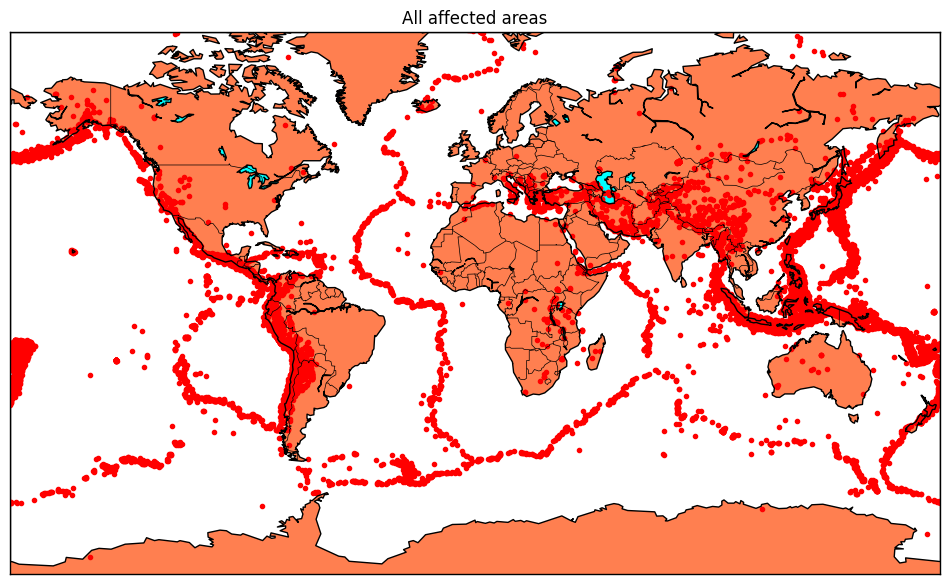

In [102]:
fig = plt.figure(figsize=(12,10))
plt.title("All affected areas")
m.plot(x, y, "o", markersize = 3, color = 'red')
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')
m.drawmapboundary()
m.drawcountries()
plt.show()

In [85]:
X = final_data[['Timestamp', 'Latitude', 'Longitude']]
y = final_data[['Magnitude','Depth']]

In [12]:
!pip install scikit-learn

In [86]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, X_test.shape)

(14045, 3) (9364, 3) (14045, 2) (9364, 3)


In [87]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(random_state=42)
reg.fit(X_train, y_train)
y_predict = reg.predict(X_test)


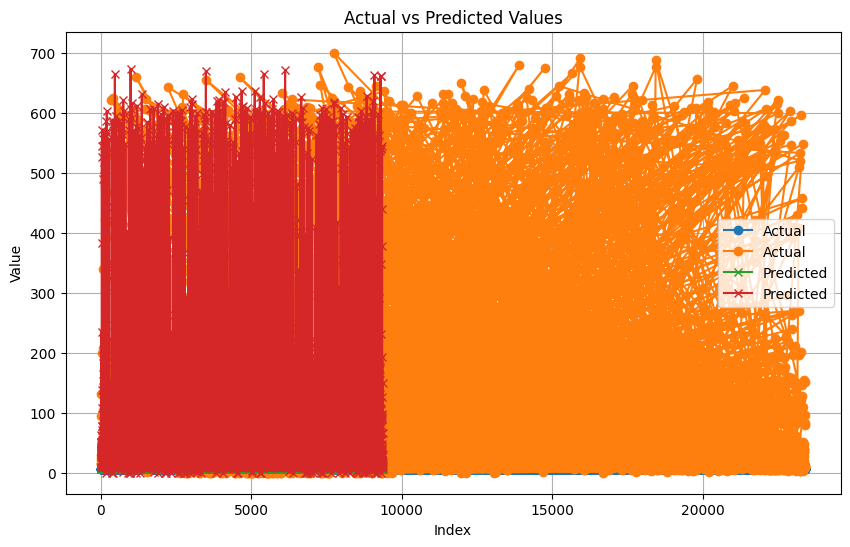

In [88]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_predict, label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=30)
print(X_train.shape, X_test.shape, y_train.shape, X_test.shape)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

reg = RandomForestRegressor(random_state=50)
#input contains timestamp, latitude, longitude
reg.fit(X_train, y_train)
# X_test = [[-157630542.0],[19.246],[145.616]]
y_predict = reg.predict(X_test)
accuracy = r2_score(y_test, y_predict)
print("Accuracy:", accuracy)


(14045, 3) (9364, 3) (14045, 2) (9364, 3)
Accuracy: 0.36284099314544305


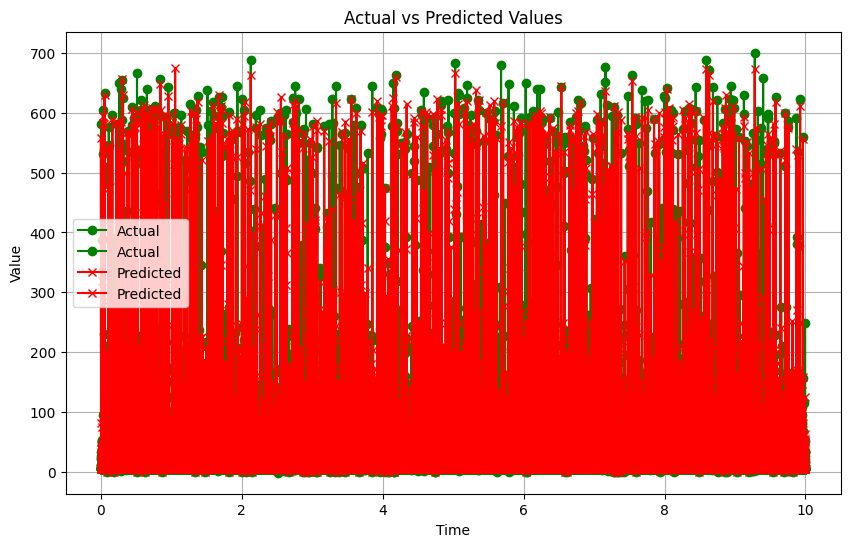

In [90]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have actual and predicted values
# Sample data
x = np.linspace(0, 10, len(y_test))  # Time steps for the waveform
# y_sin = np.sin(x)  # Sine wave for visualization

# Plotting the sine wave and the actual/predicted values
plt.figure(figsize=(10, 6))
# plt.plot(x, y_sin, label='Sine Wave', color='blue')
plt.plot(x, y_test, label='Actual', marker='o', color='green')
plt.plot(x, y_predict, label='Predicted', marker='x', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

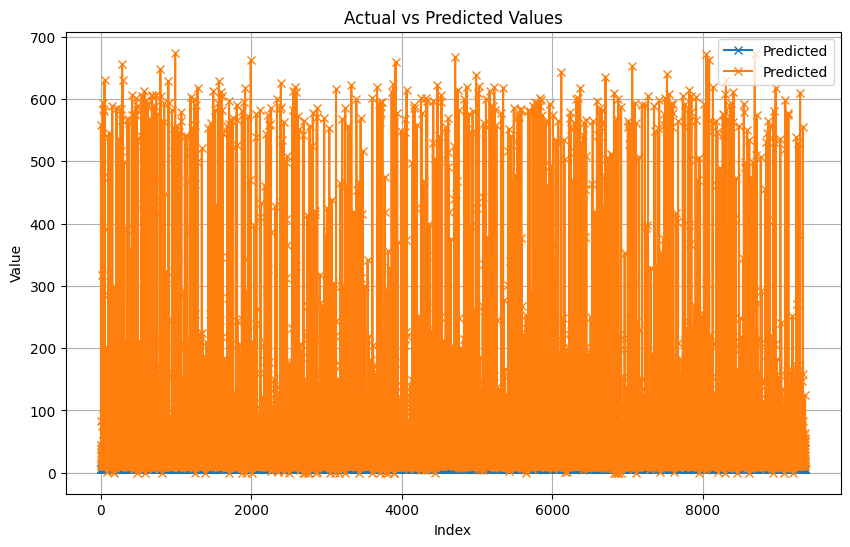

In [91]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_predict, label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# X_test
X_train

In [ ]:
!pip install mplcursors

In [18]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':[10, 20, 50, 100, 200, 500]}

grid_obj = GridSearchCV(reg, parameters)
grid_fit = grid_obj.fit(X_train, y_train)
best_fit = grid_fit.best_estimator_
best_fit.predict(X_test)

array([[  5.886 ,  43.031 ],
       [  5.82  ,  31.3982],
       [  6.0124,  39.5216],
       ...,
       [  6.294 ,  22.9908],
       [  5.9218, 592.385 ],
       [  5.7894,  39.2764]])

In [20]:
best_fit.score(X_test, y_test)

0.3969343336896403

# **Neural Network**

In [30]:
from keras.models import Sequential
from keras.layers import Dense

def create_model(neurons, activation, optimizer, loss):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(3,)))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model

In [ ]:
!pip install scikeras

In [67]:
from scikeras.wrappers import KerasClassifier

model = KerasClassifier(build_fn=create_model, verbose=0)

# neurons = [16, 64, 128, 256]
neurons = [16]
# batch_size = [10, 20, 50, 100]
batch_size = [10]
epochs = [10]
# activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear', 'exponential']
activation = ['sigmoid', 'relu']
# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
optimizer = ['SGD', 'Adadelta']
loss = ['squared_hinge']

param_grid = dict(neurons=neurons, batch_size=batch_size, epochs=epochs, activation=activation, optimizer=optimizer, loss=loss)

In [66]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

# Print results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

ValueError: Invalid parameter activation for estimator KerasClassifier.
This issue can likely be resolved by setting this parameter in the KerasClassifier constructor:
`KerasClassifier(activation=sigmoid)`
Check the list of available parameters with `estimator.get_params().keys()`

In [46]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(3,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD', loss='squared_hinge', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, batch_size=10, epochs=20, verbose=1, validation_data=(X_test, y_test))

In [ ]:
[test_loss, test_acc] = model.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

In [ ]:
model.save('earthquake.h5')